In [53]:
# ---------------------------------------------------------
# Project: Nutritional Evaluation for Diabetes Meal Plans
# Author: [Your Name or Org]
# Description:
#   - Evaluates two meal plans (Plan A and Plan B) from Excel data
#   - Aggregates daily totals, computes weekly averages
#   - Compares against real-world diabetes nutrition guidelines
#   - Outputs metrics: MAE, MSE, RMSE, and Z-scores per plan
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# General display and plotting settings
pd.set_option("display.float_format", lambda x: f"{x:.2f}")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

# File configuration
DATA_PATH = Path("meal_to_yoga_top1_contrastive_diabetes.xlsx")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"❌ File not found: {DATA_PATH.resolve()}")

print(f"✅ Loaded environment. Found dataset: {DATA_PATH.name}")


✅ Loaded environment. Found dataset: meal_to_yoga_top1_contrastive_diabetes.xlsx


In [54]:
# ---------------------------------------------------------
# Load dataset and inspect structure
# ---------------------------------------------------------

df = pd.read_excel(DATA_PATH, sheet_name=None)
sheet_name = list(df.keys())[0]  # use first sheet if multiple
df = df[sheet_name]

print(f"📘 Loaded sheet: {sheet_name}")
print("Shape:", df.shape)
display(df.head(5))

print("\nAvailable columns:")
for c in df.columns:
    print(" -", c)


📘 Loaded sheet: Sheet1
Shape: (42, 24)


,meal_index,meal_plan,meal_day,meal_time,meal_name,meal_description,Calories (kcal),Total_Fat (g),Protein (g),Carbohydrates (g),Dietary_Fiber (g),Added_Sugar (g),"Omega-3 (ALA, g)",EPA + DHA (mg),Selenium (µg),Magnesium (mg),yoga_index,yoga_plan,yoga_day,yoga_time,yoga_detailed,yoga_exercise,yoga_precautions,similarity
0,0,Plan A,Monday,Morning,Oatmeal with flaxseed and blueberries,Cooked oats with flaxseed and fresh blueberries.,581.70,23.00,36.50,74.00,14.20,0.30,0.43,105.00,23.40,140.20,21,Plan A,Monday,Morning,Perform Ardha Matsyendrasana and Vajrasana for...,Engage in 30 minutes of moderate-intensity bri...,Check blood glucose before and after exercise....,0.27
1,1,Plan A,Monday,Afternoon,Grilled salmon with quinoa and spinach,Salmon fillet served with quinoa and sautéed s...,603.50,22.60,23.30,54.50,13.60,1.00,0.32,113.90,22.30,125.50,34,Plan A,Friday,Afternoon,Perform Ardha Matsyendrasana and Vajrasana for...,Engage in 30 minutes of moderate-intensity bri...,Check blood glucose before and after exercise....,0.16
2,2,Plan A,Monday,Evening,Pan-seared tuna with sweet potato mash,Tuna steak with mashed sweet potatoes and gree...,504.30,19.00,31.50,68.90,10.90,4.30,0.35,91.10,24.80,118.30,23,Plan A,Monday,Evening,Perform Ardha Matsyendrasana and Vajrasana for...,Engage in 30 minutes of moderate-intensity bri...,Check blood glucose before and after exercise....,0.17
3,3,Plan A,Tuesday,Morning,Oatmeal with flaxseed and blueberries,Cooked oats with flaxseed and fresh blueberries.,514.20,20.00,38.80,55.50,12.90,1.40,0.59,151.30,24.90,131.60,30,Plan A,Thursday,Morning,Perform Ardha Matsyendrasana and Vajrasana for...,Engage in 30 minutes of moderate-intensity bri...,Check blood glucose before and after exercise....,0.27
4,4,Plan A,Tuesday,Afternoon,Lentil and vegetable soup,"Hearty soup made with lentils, carrots, and ce...",516.90,17.50,38.40,58.30,9.10,1.20,0.32,113.80,18.00,116.10,25,Plan A,Tuesday,Afternoon,Perform Ardha Matsyendrasana and Vajrasana for...,Engage in 30 minutes of moderate-intensity bri...,Check blood glucose before and after exercise....,0.29



Available columns:
 - meal_index
 - meal_plan
 - meal_day
 - meal_time
 - meal_name
 - meal_description
 - Calories (kcal)
 - Total_Fat (g)
 - Protein (g)
 - Carbohydrates (g)
 - Dietary_Fiber (g)
 - Added_Sugar (g)
 - Omega-3 (ALA, g)
 - EPA + DHA (mg)
 - Selenium (µg)
 - Magnesium (mg)
 - yoga_index
 - yoga_plan
 - yoga_day
 - yoga_time
 - yoga_detailed
 - yoga_exercise
 - yoga_precautions
 - similarity


In [55]:
# ---------------------------------------------------------
# Normalize column names and values
# ---------------------------------------------------------

def canon(text):
    """Standardize text: lowercase, trim, replace spaces with underscores."""
    if pd.isna(text):
        return text
    return "_".join(str(text).strip().lower().split())

# Normalize all column names
df.columns = [canon(c) for c in df.columns]

# Identify key columns
plan_col = next((c for c in df.columns if "plan" in c), None)
day_col = next((c for c in df.columns if "day" in c or "meal_day" in c), None)

if not plan_col or not day_col:
    raise ValueError("❌ Could not auto-detect 'plan' or 'day' column.")

# Canonicalize plan and day column values
df[plan_col] = df[plan_col].astype(str).apply(canon)
df[day_col] = df[day_col].astype(str).apply(canon)

print(f"Detected Plan Column: {plan_col}")
print(f"Detected Day Column: {day_col}")
print("\nUnique Plans:", df[plan_col].unique())
print("Unique Days:", df[day_col].unique())


Detected Plan Column: meal_plan
Detected Day Column: meal_day

Unique Plans: ['plan_a' 'plan_b']
Unique Days: ['monday' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday']


In [58]:
# ---------------------------------------------------------
# Map dataset columns to standardized nutrient names
# ---------------------------------------------------------

nutrient_patterns = {
    "Calories (kcal)": ["calorie", "energy", "kcal"],
    "Total Fat (g)": ["fat"],
    "Protein (g)": ["protein"],
    "Carbohydrates (g)": ["carbohydrate", "carbs"],
    "Dietary Fiber (g)": ["fiber", "fibre"],
    "Added Sugar (g)": ["sugar"],
    "Omega-3 (ALA) (g)": ["omega", "ala"],
    "EPA + DHA (mg)": ["epa", "dha"],
    "Selenium (ug)": ["selenium", "se"],
    "Magnesium (mg)": ["magnesium", "mg"],
}

matched = {}
for friendly, pats in nutrient_patterns.items():
    found = None
    for p in pats:
        for col in df.columns:
            if p in col:
                found = col
                break
        if found:
            break
    matched[friendly] = found

print("🔍 Matched nutrient columns:")
for k, v in matched.items():
    print(f"  {k:22s} → {v}")

found_cols = [v for v in matched.values() if v is not None]
df = df[[plan_col, day_col] + found_cols].copy()

# Ensure numeric
for c in found_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("\nCleaned dataset shape:", df.shape)
display(df.head(10))


🔍 Matched nutrient columns:
  Calories (kcal)        → calories_(kcal)
  Total Fat (g)          → total_fat_(g)
  Protein (g)            → protein_(g)
  Carbohydrates (g)      → carbohydrates_(g)
  Dietary Fiber (g)      → dietary_fiber_(g)
  Added Sugar (g)        → added_sugar_(g)
  Omega-3 (ALA) (g)      → omega-3_(ala,_g)
  EPA + DHA (mg)         → epa_+_dha_(mg)
  Selenium (ug)          → selenium_(µg)
  Magnesium (mg)         → magnesium_(mg)

Cleaned dataset shape: (42, 12)


,meal_plan,meal_day,calories_(kcal),total_fat_(g),protein_(g),carbohydrates_(g),dietary_fiber_(g),added_sugar_(g),"omega-3_(ala,_g)",epa_+_dha_(mg),selenium_(µg),magnesium_(mg)
0,plan_a,monday,581.70,23.00,36.50,74.00,14.20,0.30,0.43,105.00,23.40,140.20
1,plan_a,monday,603.50,22.60,23.30,54.50,13.60,1.00,0.32,113.90,22.30,125.50
2,plan_a,monday,504.30,19.00,31.50,68.90,10.90,4.30,0.35,91.10,24.80,118.30
3,plan_a,tuesday,514.20,20.00,38.80,55.50,12.90,1.40,0.59,151.30,24.90,131.60
4,plan_a,tuesday,516.90,17.50,38.40,58.30,9.10,1.20,0.32,113.80,18.00,116.10
5,plan_a,tuesday,618.30,15.30,20.50,65.30,8.60,3.60,0.51,90.00,23.60,138.10
6,plan_a,wednesday,616.50,18.50,28.50,55.90,13.10,0.50,0.46,81.10,21.70,132.80
7,plan_a,wednesday,636.50,24.80,21.80,60.10,14.80,1.20,0.40,161.90,19.20,119.80
8,plan_a,wednesday,568.20,23.90,24.50,70.00,14.30,3.30,0.36,154.50,16.10,128.60
9,plan_a,thursday,623.80,22.40,28.80,50.60,8.00,3.60,0.45,98.30,21.80,142.00


In [64]:
# ---------------------------------------------------------
# Compute daily totals for each plan
# ---------------------------------------------------------

daily_totals = (
    df.groupby([plan_col, day_col])[found_cols]
      .sum()
      .reset_index()
      .sort_values([plan_col, day_col])
      .set_index([plan_col, day_col])
)

print("✅ Daily Totals computed:")
display(daily_totals.head(10))


✅ Daily Totals computed:


calories_(kcal)  total_fat_(g)  protein_(g)  \
meal_plan meal_day                                                 
plan_a    friday             2208.90          58.10        89.00   
          monday             1689.50          64.60        91.30   
          saturday           1822.10          50.00        86.90   
          sunday             1816.10          53.50        84.30   
          thursday           1738.80          63.00        87.40   
          tuesday            1649.40          52.80        97.70   
          wednesday          1821.20          67.20        74.80   
plan_b    friday             1867.40          54.50        78.50   
          monday             2041.80          67.50        99.30   
          saturday           2177.30          54.20        94.90   

                     carbohydrates_(g)  dietary_fiber_(g)  added_sugar_(g)  \
meal_plan meal_day                                                           
plan_a    friday                167.60              35.70             8.60   
          monday                197.40              38.70             5.60   
          saturday              197.70              32.10             8.00   
          sunday                212.60              33.00             6.40   
          thursday              158.10              31.00            12.70   
          tuesday               179.10              30.60             6.20   
          wednesday             186.00              42.20             5.00   
plan_b    friday                178.60              35.30             5.50   
          monday                170.90              30.90             9.60   
          saturday              204.40              32.20             8.40   

                     omega-3_(ala,_g)  epa_+_dha_(mg)  selenium_(µg)  \
meal_plan meal_day                                                     
plan_a    friday                 1.56          351.30          60.20   
          monday                 1.10          310.00          70.50   
          saturday               1.49          467.90          69.80   
          sunday                 1.38          369.00          61.50   
          thursday               1.40          422.80          70.20   
          tuesday                1.42          355.10          66.50   
          wednesday              1.22          397.50          57.00   
plan_b    friday                 1.35          457.60          59.00   
          monday                 1.35          435.70          56.90   
          saturday               1.70          445.60          57.50   

                     magnesium_(mg)  
meal_plan meal_day                   
plan_a    friday             393.10  
          monday             384.00  
          saturday           354.10  
          sunday             367.90  
          thursday           399.90  
          tuesday            385.80  
          wednesday          381.20  
plan_b    friday             378.70  
          monday             386.90  
          saturday           335.00

In [65]:
# ---------------------------------------------------------
# Compute weekly averages per plan
# ---------------------------------------------------------

weekly_avg = daily_totals.groupby(plan_col)[found_cols].mean()

# Create human-friendly nutrient labels
dataset_to_friendly = {v: k for k, v in matched.items() if v is not None}

def make_series(plan_name):
    s = weekly_avg.loc[plan_name].rename(index=dataset_to_friendly)
    s.name = plan_name
    return s

weekly_avg_main = make_series("plan_a")
weekly_avg_alt = make_series("plan_b")

print("📊 Weekly Average - Plan A (Main)")
display(weekly_avg_main.round(2))
print("\n📊 Weekly Average - Plan B (Alternate)")
display(weekly_avg_alt.round(2))


📊 Weekly Average - Plan A (Main)


Calories (kcal)     1820.86
Total Fat (g)         58.46
Protein (g)           87.34
Carbohydrates (g)    185.50
Dietary Fiber (g)     34.76
Added Sugar (g)        7.50
Omega-3 (ALA) (g)      1.37
EPA + DHA (mg)       381.94
Selenium (ug)         65.10
Magnesium (mg)       380.86
Name: plan_a, dtype: float64


📊 Weekly Average - Plan B (Alternate)


Calories (kcal)     1932.09
Total Fat (g)         57.54
Protein (g)           92.79
Carbohydrates (g)    186.66
Dietary Fiber (g)     33.41
Added Sugar (g)        7.17
Omega-3 (ALA) (g)      1.44
EPA + DHA (mg)       396.07
Selenium (ug)         59.51
Magnesium (mg)       361.40
Name: plan_b, dtype: float64

In [66]:
# ---------------------------------------------------------
# Midpoints based on diabetes nutritional guidelines
# ---------------------------------------------------------

guideline_mid = pd.Series({
    "Calories (kcal)": 2000,
    "Total Fat (g)": (44 + 78) / 2,
    "Protein (g)": (50 + 120) / 2,
    "Carbohydrates (g)": (180 + 275) / 2,
    "Dietary Fiber (g)": (25 + 40) / 2,
    "Added Sugar (g)": (0 + 25) / 2,
    "Omega-3 (ALA) (g)": (1.1 + 1.6) / 2,
    "EPA + DHA (mg)": (250 + 500) / 2,
    "Selenium (ug)": 55,
    "Magnesium (mg)": (310 + 420) / 2,
})

guideline_mid = guideline_mid.reindex(weekly_avg_main.index)
display(guideline_mid)


Calories (kcal)     2000.00
Total Fat (g)         61.00
Protein (g)           85.00
Carbohydrates (g)    227.50
Dietary Fiber (g)     32.50
Added Sugar (g)       12.50
Omega-3 (ALA) (g)      1.35
EPA + DHA (mg)       375.00
Selenium (ug)         55.00
Magnesium (mg)       365.00
dtype: float64

In [67]:
# ---------------------------------------------------------
# Compute absolute and percentage errors
# ---------------------------------------------------------

def compute_error_table(pred_series, ref_series):
    df_err = pd.DataFrame({
        "Predicted": pred_series,
        "Guideline": ref_series
    })
    df_err["Absolute Error"] = (df_err["Predicted"] - df_err["Guideline"]).abs()
    df_err["Percentage Error (%)"] = (df_err["Absolute Error"] / df_err["Guideline"]) * 100
    return df_err.round(2)

main_errors = compute_error_table(weekly_avg_main, guideline_mid)
alt_errors = compute_error_table(weekly_avg_alt, guideline_mid)

print("📊 Main Plan - Predicted vs Guideline")
display(main_errors)

print("\n📊 Alternate Plan - Predicted vs Guideline")
display(alt_errors)


📊 Main Plan - Predicted vs Guideline


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),1820.86,2000.00,179.14,8.96
Total Fat (g),58.46,61.00,2.54,4.17
Protein (g),87.34,85.00,2.34,2.76
Carbohydrates (g),185.50,227.50,42.00,18.46
Dietary Fiber (g),34.76,32.50,2.26,6.95
Added Sugar (g),7.50,12.50,5.00,40.00
Omega-3 (ALA) (g),1.37,1.35,0.02,1.27
EPA + DHA (mg),381.94,375.00,6.94,1.85
Selenium (ug),65.10,55.00,10.10,18.36
Magnesium (mg),380.86,365.00,15.86,4.34



📊 Alternate Plan - Predicted vs Guideline


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),1932.09,2000.00,67.91,3.40
Total Fat (g),57.54,61.00,3.46,5.67
Protein (g),92.79,85.00,7.79,9.16
Carbohydrates (g),186.66,227.50,40.84,17.95
Dietary Fiber (g),33.41,32.50,0.91,2.81
Added Sugar (g),7.17,12.50,5.33,42.63
Omega-3 (ALA) (g),1.44,1.35,0.09,6.46
EPA + DHA (mg),396.07,375.00,21.07,5.62
Selenium (ug),59.51,55.00,4.51,8.21
Magnesium (mg),361.40,365.00,3.60,0.99


In [68]:
# ---------------------------------------------------------
# Evaluate numeric metrics
# ---------------------------------------------------------

def compute_metrics(errors_df):
    abs_err = errors_df["Absolute Error"].dropna()
    mae = abs_err.mean()
    mse = (abs_err ** 2).mean()
    rmse = np.sqrt(mse)
    return pd.DataFrame({"MAE": [mae], "MSE": [mse], "RMSE": [rmse]}).round(2)

main_metrics = compute_metrics(main_errors)
alt_metrics = compute_metrics(alt_errors)

print("📈 Main Plan - Error Metrics")
display(main_metrics)
print("\n📈 Alternate Plan - Error Metrics")
display(alt_metrics)


📈 Main Plan - Error Metrics


,MAE,MSE,RMSE
0,26.62,3429.89,58.57



📈 Alternate Plan - Error Metrics


,MAE,MSE,RMSE
0,15.55,685.88,26.19


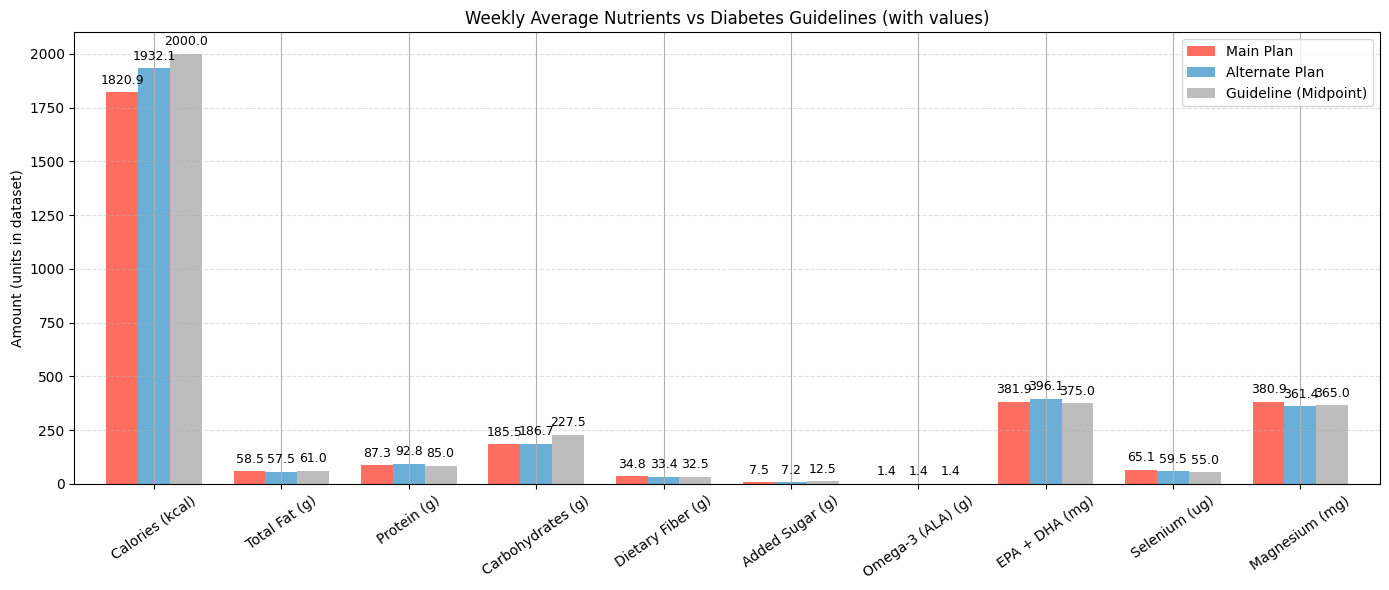

In [78]:
# Cell: Annotated grouped bar chart (show exact numbers above each bar)
import matplotlib.pyplot as plt
import numpy as np

# comparison_df must exist (index = nutrients, columns = ["Main Plan","Alternate Plan","Guideline (Midpoint)"])
fig, ax = plt.subplots(figsize=(14,6))
bars = comparison_df.plot(kind="bar", ax=ax, width=0.75, color=["#FF6F61", "#6BAED6", "#BDBDBD"])

ax.set_title("Weekly Average Nutrients vs Diabetes Guidelines (with values)")
ax.set_ylabel("Amount (units in dataset)")
ax.set_xlabel("") 
ax.tick_params(axis='x', rotation=35)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# annotate each bar with its numeric value
# ax.patches order: grouped bars left→right across groups
for p in ax.patches:
    # height may be numpy.nan if missing; guard against it
    h = p.get_height()
    if np.isnan(h):
        continue
    # compute label position above bar
    ax.annotate(f"{h:.1f}",
                (p.get_x() + p.get_width() / 2, h),
                ha='center', va='bottom',
                fontsize=9, xytext=(0, 4), textcoords="offset points")

plt.tight_layout()
plt.show()


,Guideline (Midpoint),Predicted (Plan A),Predicted (Plan B),Z-Score (Plan A),Z-Score (Plan B)
Calories (kcal),2000.00,1820.86,1932.09,-0.31,-0.12
Total Fat (g),61.00,58.46,57.54,-0.00,-0.01
Protein (g),85.00,87.34,92.79,0.00,0.01
Carbohydrates (g),227.50,185.50,186.66,-0.07,-0.07
Dietary Fiber (g),32.50,34.76,33.41,0.00,0.00
Added Sugar (g),12.50,7.50,7.17,-0.01,-0.01
Omega-3 (ALA) (g),1.35,1.37,1.44,0.00,0.00
EPA + DHA (mg),375.00,381.94,396.07,0.01,0.04
Selenium (ug),55.00,65.10,59.51,0.02,0.01
Magnesium (mg),365.00,380.86,361.40,0.03,-0.01


🔹 Average absolute Z-score for Plan A = 0.046
🔹 Average absolute Z-score for Plan B = 0.027


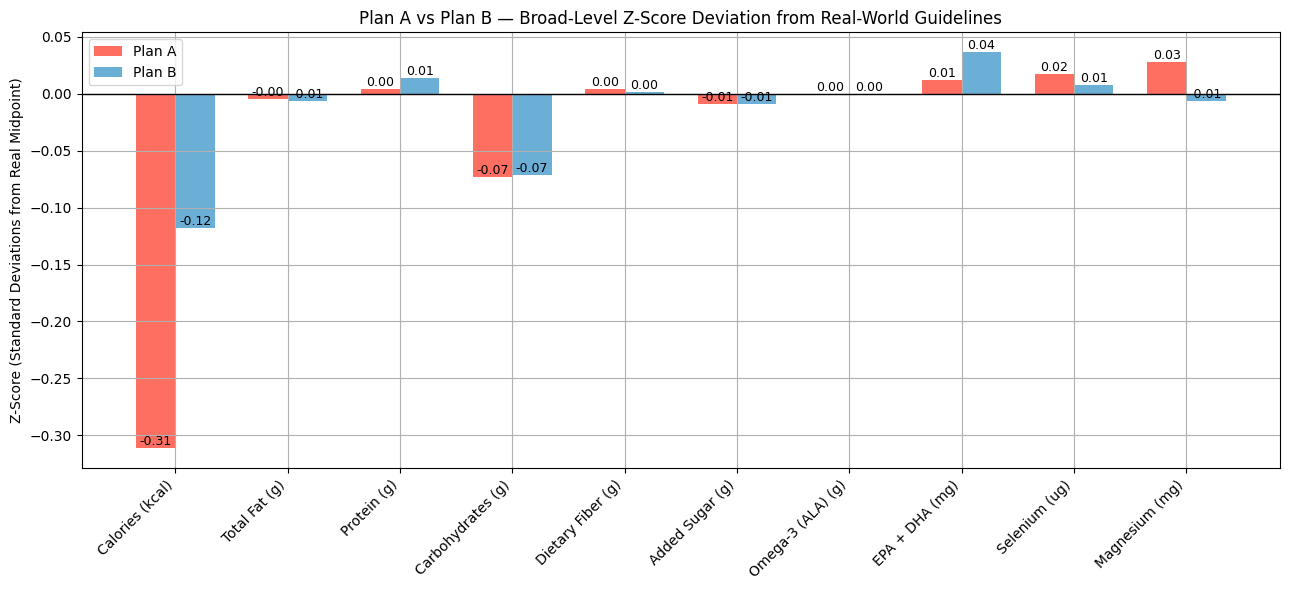

In [83]:
# ---------------------------------------------------------
# Broad-Level Z-Score Evaluation (Plan A & Plan B vs Real Guidelines)
# ---------------------------------------------------------

# 1. Align predicted weekly averages with the guideline index
weekly_avg_main_aligned = weekly_avg_main.reindex(guideline_mid.index)
weekly_avg_alt_aligned  = weekly_avg_alt.reindex(guideline_mid.index)
guideline_aligned       = guideline_mid.reindex(weekly_avg_main_aligned.index)

# 2. Compute z-scores (standardized deviation from real guideline midpoint)
# z = (predicted - guideline) / std(guideline values)
guideline_std = np.std(guideline_aligned.values, ddof=0)

z_main = (weekly_avg_main_aligned.values - guideline_aligned.values) / guideline_std
z_alt  = (weekly_avg_alt_aligned.values  - guideline_aligned.values) / guideline_std

z_main_series = pd.Series(z_main, index=guideline_aligned.index, name="Z-Score (Plan A)")
z_alt_series  = pd.Series(z_alt,  index=guideline_aligned.index, name="Z-Score (Plan B)")

# 3. Combine into a single comparison DataFrame
z_comparison_df = pd.DataFrame({
    "Guideline (Midpoint)": guideline_aligned,
    "Predicted (Plan A)": weekly_avg_main_aligned,
    "Predicted (Plan B)": weekly_avg_alt_aligned,
    "Z-Score (Plan A)": z_main_series,
    "Z-Score (Plan B)": z_alt_series
}).round(3)

display(z_comparison_df)

# 4. Calculate average absolute Z-score per plan
avg_abs_z_main = np.abs(z_main_series).mean()
avg_abs_z_alt  = np.abs(z_alt_series).mean()

print(f"🔹 Average absolute Z-score for Plan A = {avg_abs_z_main:.3f}")
print(f"🔹 Average absolute Z-score for Plan B = {avg_abs_z_alt:.3f}")

# 5. Visualization: Annotated bar plot comparing both plans' Z-scores
fig, ax = plt.subplots(figsize=(13,6))

bar_width = 0.35
x = np.arange(len(z_comparison_df.index))

bars1 = ax.bar(x - bar_width/2, z_main_series, width=bar_width, label="Plan A", color="#FF6F61")
bars2 = ax.bar(x + bar_width/2, z_alt_series, width=bar_width, label="Plan B", color="#6BAED6")

# Annotate exact Z values on top of bars
for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h,
                f"{h:.2f}",
                ha='center', va='bottom', fontsize=9)

ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(z_comparison_df.index, rotation=45, ha='right')
ax.set_ylabel("Z-Score (Standard Deviations from Real Midpoint)")
ax.set_title("Plan A vs Plan B — Broad-Level Z-Score Deviation from Real-World Guidelines")
ax.legend()
plt.tight_layout()
plt.show()
